# Installing necessary packages

In [30]:
!pip install pmdarima

# Import libraries and packages

In [31]:
# Data Analysis
import pandas as pd
import numpy as np

# Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

# Statistics
import statsmodels.api as sm
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from pmdarima import auto_arima
from prophet import Prophet

# Machine Learning
from sklearn.metrics import mean_squared_error

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Loggers
import logging
logging.getLogger().setLevel(logging.ERROR)

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Set up

In [33]:
# Reading the file
df = pd.read_csv('/content/drive/My Drive/sfcrime_uni.csv', parse_dates = ['datetime'])
df.rename({'Unnamed: 0': 'IncidentId'}, inplace = True, axis = 1)
print(df.shape)
df.head()

(3398, 15)


,IncidentId,datetime,Incident Category,Longitude,Latitude,date,year,hour,dayOfWeek,TimeOfDay,IsWeekend,IsHoliday,month,day,IsSchoolDay
0,2114,2022-10-28 02:50:00,Lost Property,-122.398564,37.788981,2022-10-28,2022,2,Friday,Rest,False,False,10,31,True
1,2657,2023-03-24 15:30:00,Other Miscellaneous,-122.398564,37.788981,2023-03-24,2023,15,Friday,Afternoon Class,False,False,3,31,True
2,4528,2023-09-19 23:15:00,Larceny Theft,-122.400503,37.787450,2023-09-19,2023,23,Tuesday,Rest,False,False,9,30,True
3,5548,2023-10-03 06:29:00,Malicious Mischief,-122.398564,37.788981,2023-10-03,2023,6,Tuesday,Rest,False,False,10,31,True
4,5556,2023-10-03 10:00:00,Larceny Theft,-122.400809,37.787699,2023-10-03,2023,10,Tuesday,Morning Class,False,False,10,31,True


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3398 entries, 0 to 3397
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   IncidentId         3398 non-null   int64         
 1   datetime           3398 non-null   datetime64[ns]
 2   Incident Category  3398 non-null   object        
 3   Longitude          3398 non-null   float64       
 4   Latitude           3398 non-null   float64       
 5   date               3398 non-null   object        
 6   year               3398 non-null   int64         
 7   hour               3398 non-null   int64         
 8   dayOfWeek          3398 non-null   object        
 9   TimeOfDay          3398 non-null   object        
 10  IsWeekend          3398 non-null   bool          
 11  IsHoliday          3398 non-null   bool          
 12  month              3398 non-null   int64         
 13  day                3398 non-null   int64         
 14  IsSchool

In [35]:
df.set_index('datetime', inplace = True)

In [36]:
monthly = df.resample('M').count()['IncidentId'].reset_index(name = "Count").set_index('datetime')
print(monthly.shape)
monthly.head()

(250, 1)


,Count
datetime,
2003-01-31,19
2003-02-28,6
2003-03-31,7
2003-04-30,5
2003-05-31,23


# Initial plot
Giving an idea of how it looks and where to progress.

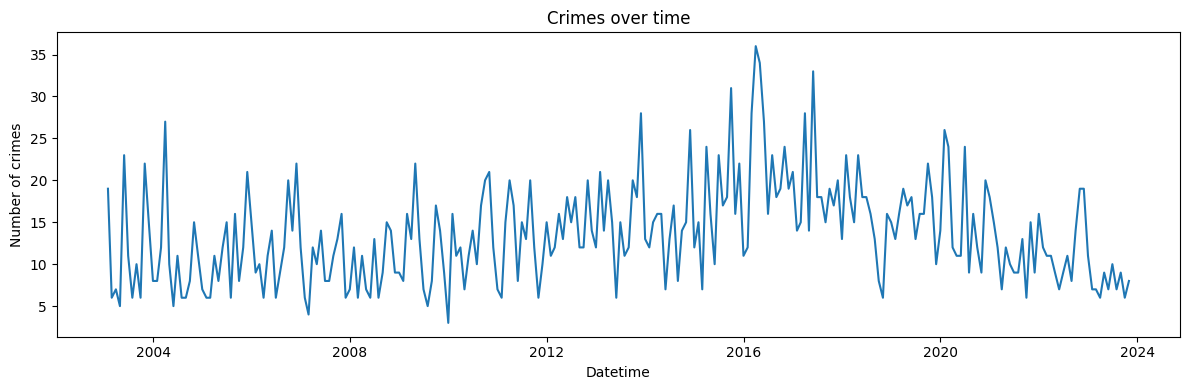

In [37]:
plt.figure(figsize=(12, 4))
plt.plot(monthly)
plt.xlabel('Datetime')
plt.ylabel('Number of crimes')
plt.title('Crimes over time')
plt.tight_layout()
plt.show()

# Train-validation split

In [38]:
split_point = int(len(monthly) * 0.8)  # For an 80%/20% train/test split
train = monthly[:split_point]
valid = monthly[split_point:]

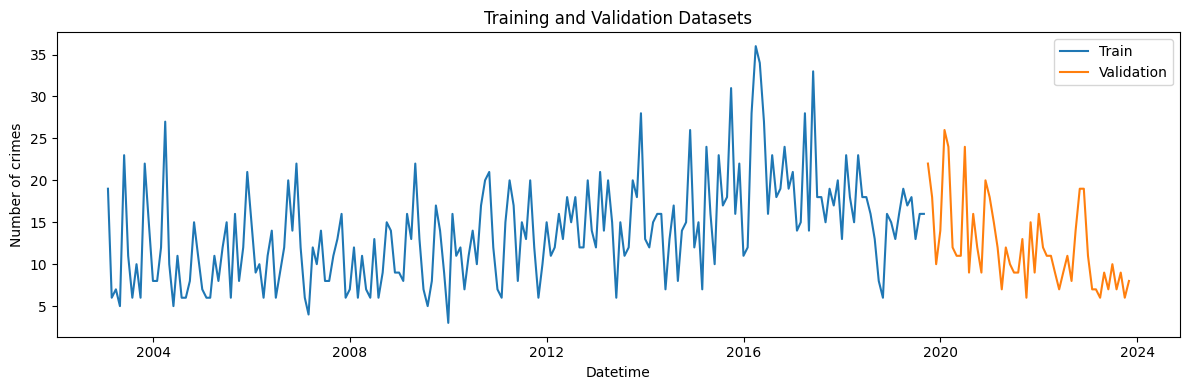

In [39]:
plt.figure(figsize=(12, 4))
plt.plot(train, label='Train')
plt.plot(valid, label='Validation')
plt.xlabel('Datetime')
plt.ylabel('Number of crimes')
plt.title('Training and Validation Datasets')
plt.legend()
plt.tight_layout()
plt.show()

# Split series into its respective components
Allow us to have a clearer view and better understanding of how to progress.

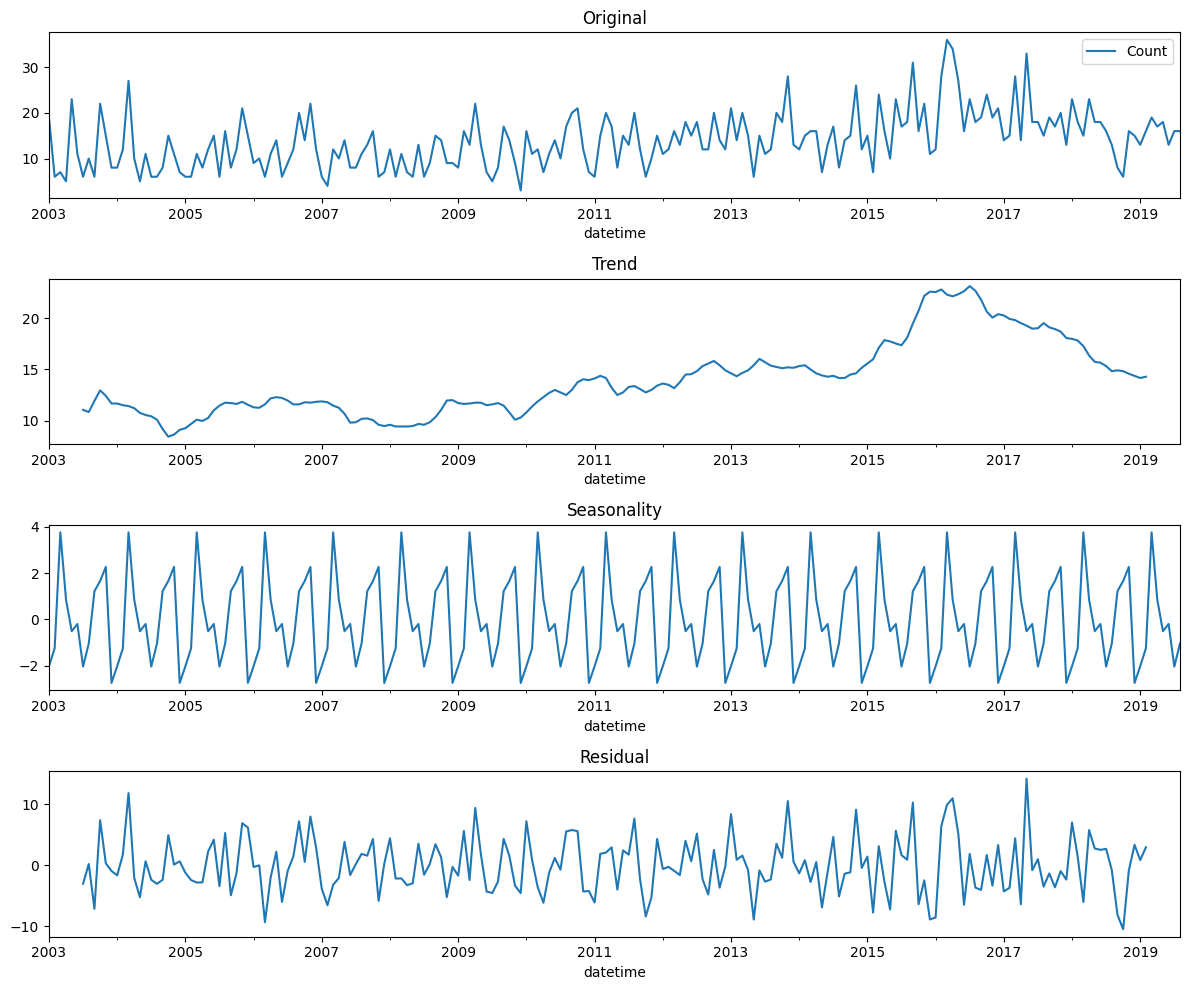

In [40]:
decomposition = sm.tsa.seasonal_decompose(train)

# Plotting the components
fig, axes = plt.subplots(4, 1, figsize=(12, 10))
train.plot(title='Original', ax=axes[0])
decomposition.trend.plot(title='Trend', ax=axes[1])
decomposition.seasonal.plot(title='Seasonality', ax=axes[2])
decomposition.resid.plot(title='Residual', ax=axes[3])
plt.tight_layout()
plt.show()

In [61]:
# Creating a function to plot the results of the forecast
def plot_forecast(forecast, model, rmse):
    plt.figure(figsize=(12,4))
    plt.plot(train, label='Training')
    plt.plot(valid, label='Actual')
    plt.plot(forecast, label='Forecast')
    plt.xlabel('Datetime')
    plt.ylabel('Count of Crime')
    plt.title(f'{model} (RMSE: {round(rmse, 2)})')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Simple Exponential Smoothing

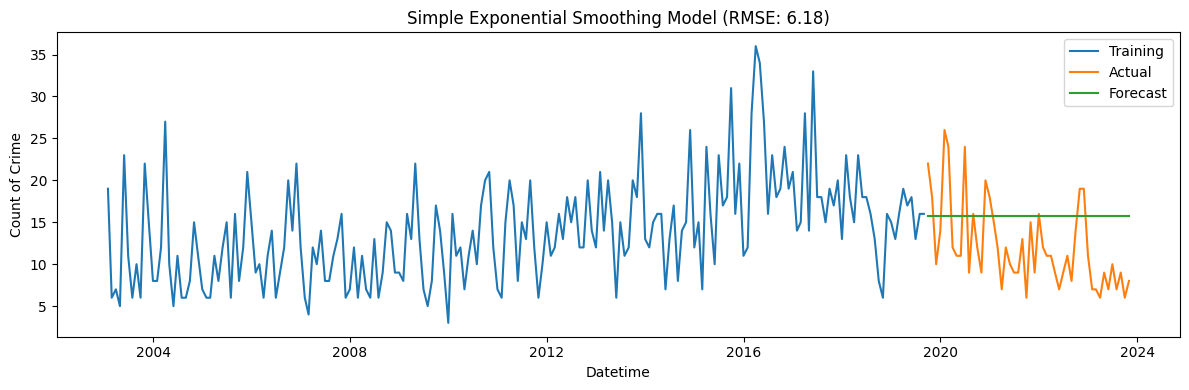

In [42]:
ses = SimpleExpSmoothing(train).fit()
ses_pred = ses.forecast(len(valid))
ses_rmse = mean_squared_error(valid, ses_pred, squared=False)

# Plotting the predictions
plot_forecast(ses_pred, 'Simple Exponential Smoothing Model', ses_rmse)

# Holt's Linear Method

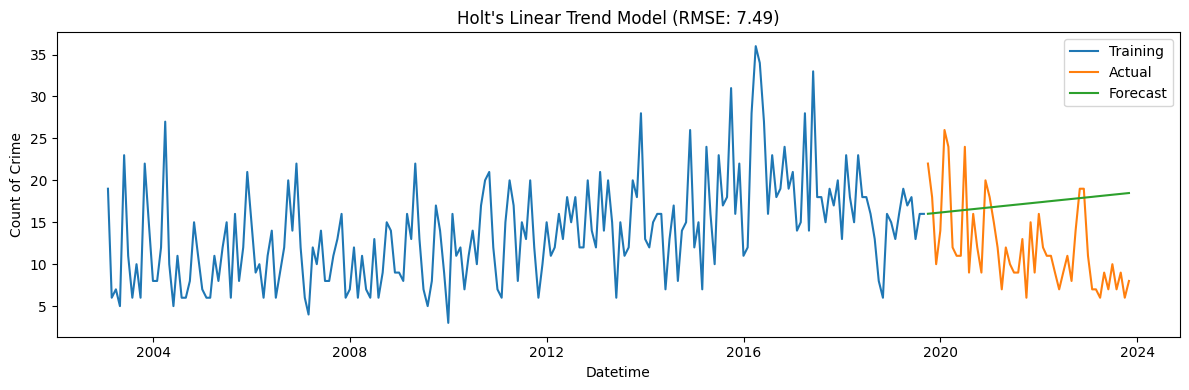

In [43]:
hltm = Holt(train).fit()
hltm_pred = hltm.forecast(len(valid))
hltm_rmse = mean_squared_error(valid, hltm_pred, squared=False)

# Plotting the predictions
plot_forecast(hltm_pred, 'Holt\'s Linear Trend Model', hltm_rmse)

# Holt's Winter Method

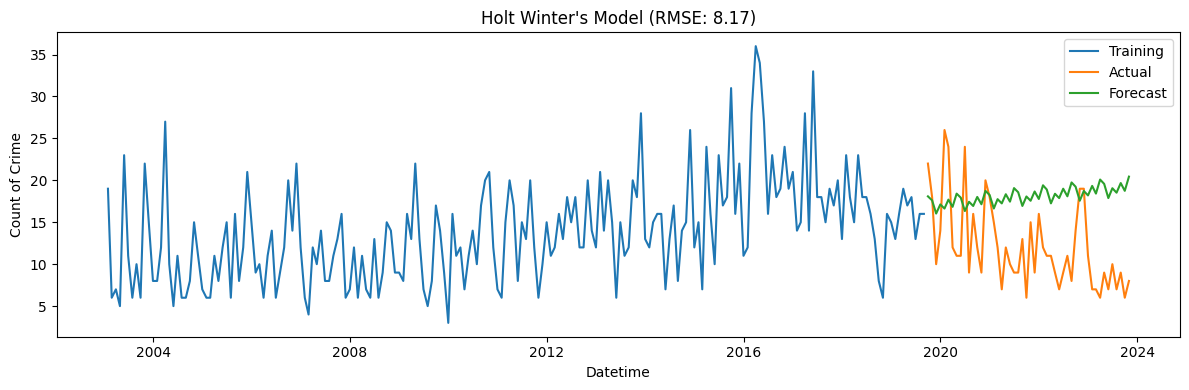

In [44]:
hwm = ExponentialSmoothing(train, seasonal_periods=7, trend='add', seasonal='add', use_boxcox=True, initialization_method='estimated').fit()
hwm_pred = hwm.forecast(len(valid))
hwm_rmse = mean_squared_error(valid, hwm_pred, squared=False)

# Plotting the predictions
plot_forecast(hwm_pred, 'Holt Winter\'s Model', hwm_rmse)

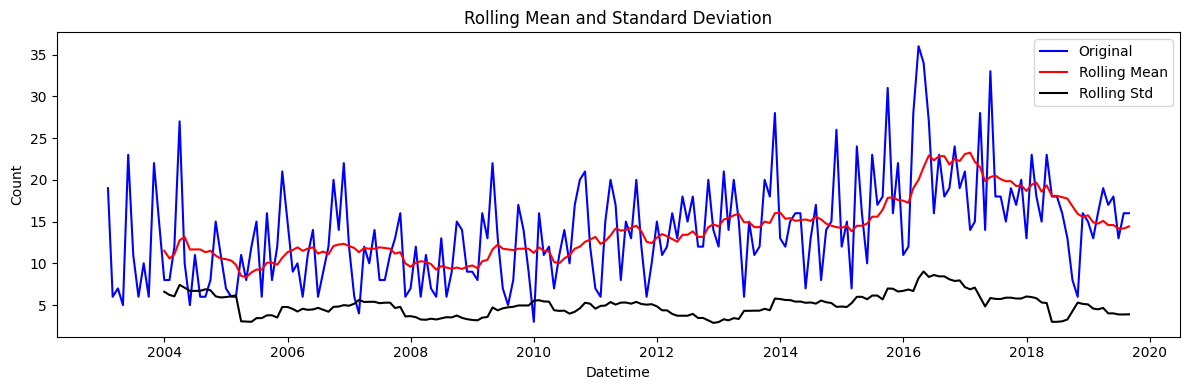

Results of Dickey-Fuller Test:
Test Statistic                  -1.558871
P-Value                          0.504214
#Lags Used                      11.000000
Number of Observations Used    188.000000
Critical Value (1%)             -3.465620
Critical Value (5%)             -2.877040
Critical Value (10%)            -2.575032
dtype: float64


In [45]:
def check_stationarity(data):
    # Determining rolling statistics
    rol_mean = data.rolling(12).mean()
    rol_std = data.rolling(12).std()

    # Plotting rolling statistics
    plt.figure(figsize=(12, 4))
    plt.plot(data, color='blue', label='Original')
    plt.plot(rol_mean, color='red', label='Rolling Mean')
    plt.plot(rol_std, color='black', label='Rolling Std')
    plt.xlabel('Datetime')
    plt.ylabel('Count')
    plt.title('Rolling Mean and Standard Deviation')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Performing Dickey-Fuller test
    results = adfuller(data)
    df_output = pd.Series(results[:4], index=['Test Statistic', 'P-Value', '#Lags Used', 'Number of Observations Used'])
    for key, value in results[4].items():
        df_output[f'Critical Value ({key})'] = value
    print(f'Results of Dickey-Fuller Test:\n{df_output}')

# Stationarity check of our daily time series
check_stationarity(train)

p-value way above 0.05, let's try box-cox transformation with appropriate lambda value as chosen by the computer.

The optimal lambda is: 0.30602061262948366


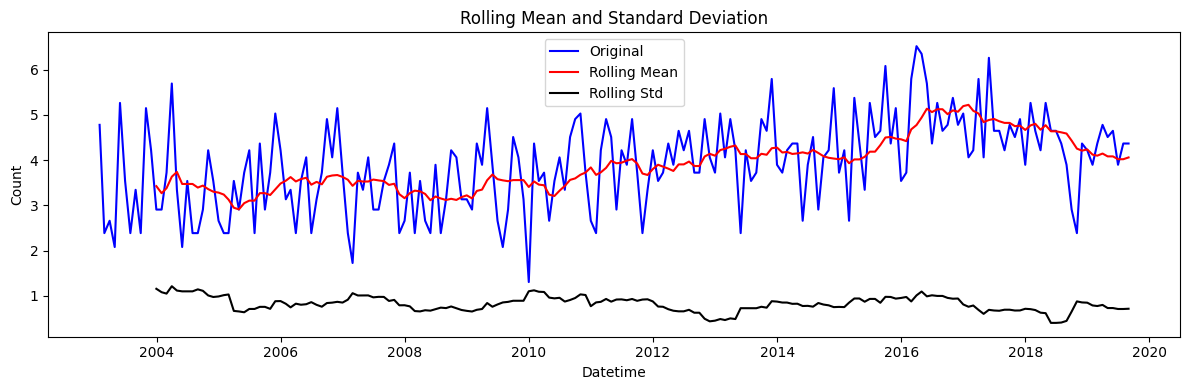

Results of Dickey-Fuller Test:
Test Statistic                  -1.524112
P-Value                          0.521552
#Lags Used                      11.000000
Number of Observations Used    188.000000
Critical Value (1%)             -3.465620
Critical Value (5%)             -2.877040
Critical Value (10%)            -2.575032
dtype: float64


In [46]:
train_tfm = train.copy()
boxcox_count, optimal_lambda = boxcox(train['Count'])
train_tfm['Count'] = boxcox(train['Count'], lmbda = optimal_lambda)
print(f"The optimal lambda is: {optimal_lambda}")
check_stationarity(train_tfm)

Using box-cox transformation does not lead to a stationarity series. Let's try differencing.

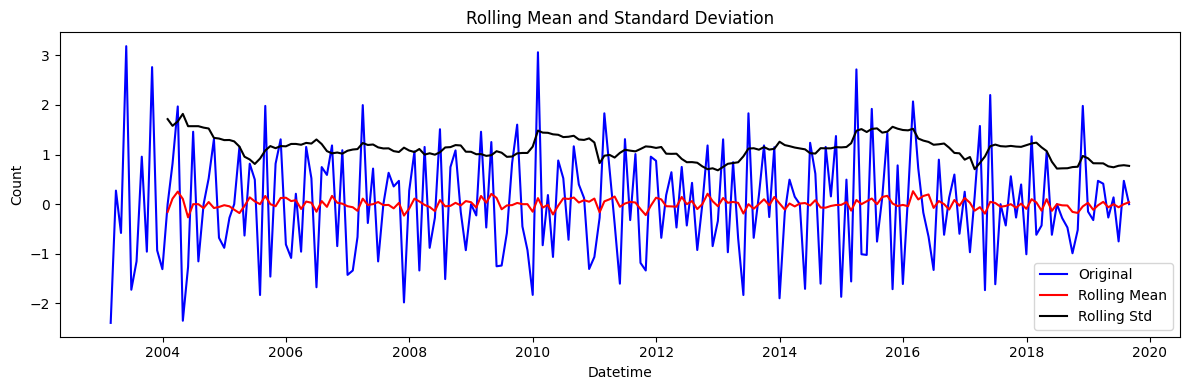

Results of Dickey-Fuller Test:
Test Statistic                -7.484560e+00
P-Value                        4.676033e-11
#Lags Used                     1.000000e+01
Number of Observations Used    1.880000e+02
Critical Value (1%)           -3.465620e+00
Critical Value (5%)           -2.877040e+00
Critical Value (10%)          -2.575032e+00
dtype: float64


In [47]:
train_tfm_diff = train_tfm - train_tfm.shift(1)
train_tfm_diff.dropna(inplace=True)
check_stationarity(train_tfm_diff)

Now series is stationary and we can proceed with ARIMA.

# ARIMA

In [48]:
arima = auto_arima(train_tfm, d=1, seasonal=False)
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  200
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -254.241
Date:                Tue, 14 Nov 2023   AIC                            514.482
Time:                        07:58:22   BIC                            524.362
Sample:                    01-31-2003   HQIC                           518.481
                         - 08-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7939      0.076    -10.412      0.000      -0.943      -0.644
ma.L2         -0.1283      0.077     -1.674      0.094      -0.279       0.022
sigma2         0.7470      0.080      9.311      0.0

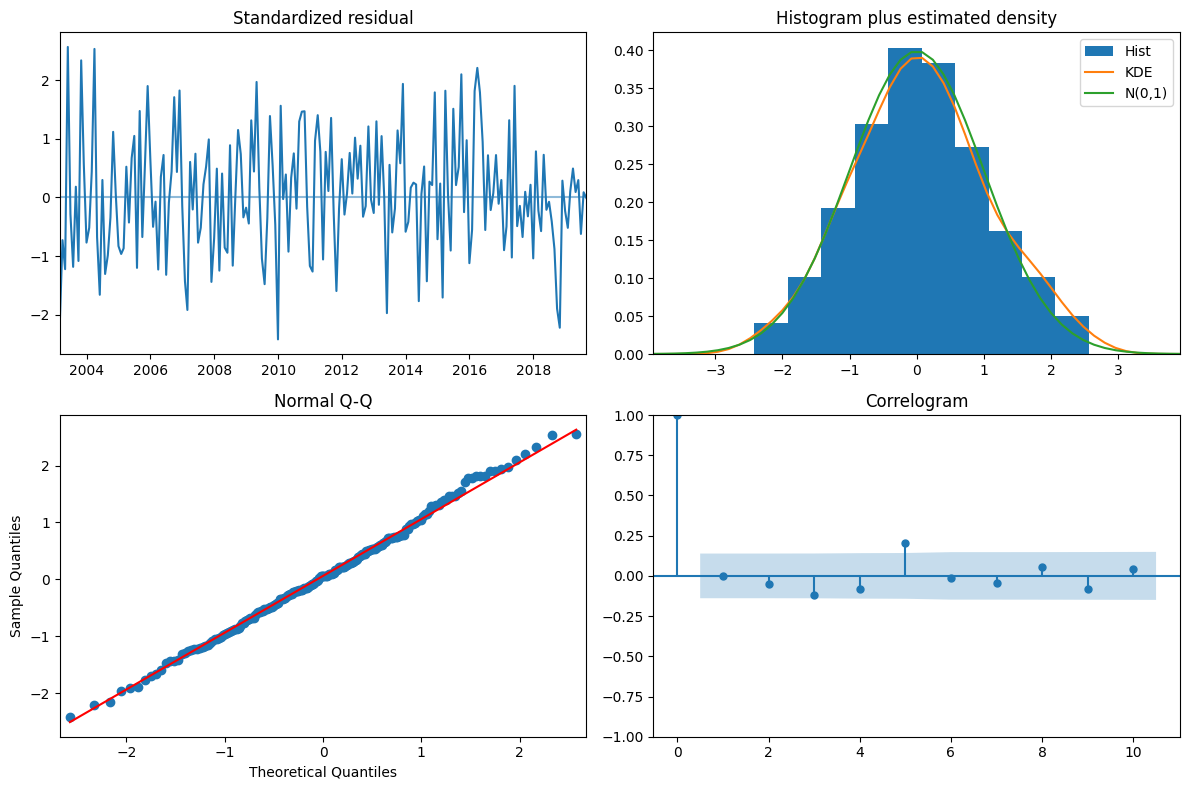

In [49]:
arima.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

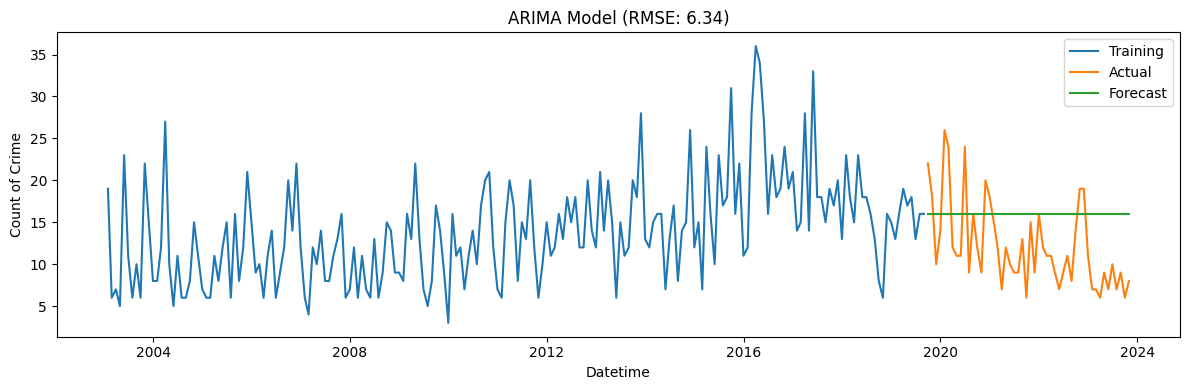

In [50]:
forecast = arima.predict(len(valid))
forecast = inv_boxcox(pd.Series(forecast, index=valid.index), optimal_lambda)
arima_rmse = mean_squared_error(valid, forecast, squared=False)

# Plotting the forecast
plot_forecast(forecast, 'ARIMA Model', arima_rmse)

# SARIMA

In [51]:
sarima = auto_arima(train_tfm, m=12, seasonal = True)

# Print the summary of the best model
print(sarima.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  200
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -251.943
Date:                              Tue, 14 Nov 2023   AIC                            513.885
Time:                                      07:59:24   BIC                            530.352
Sample:                                  01-31-2003   HQIC                           520.550
                                       - 08-31-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8037      0.077    -10.378      0.000      -0.956      -0.652
ma.L2         -0.12

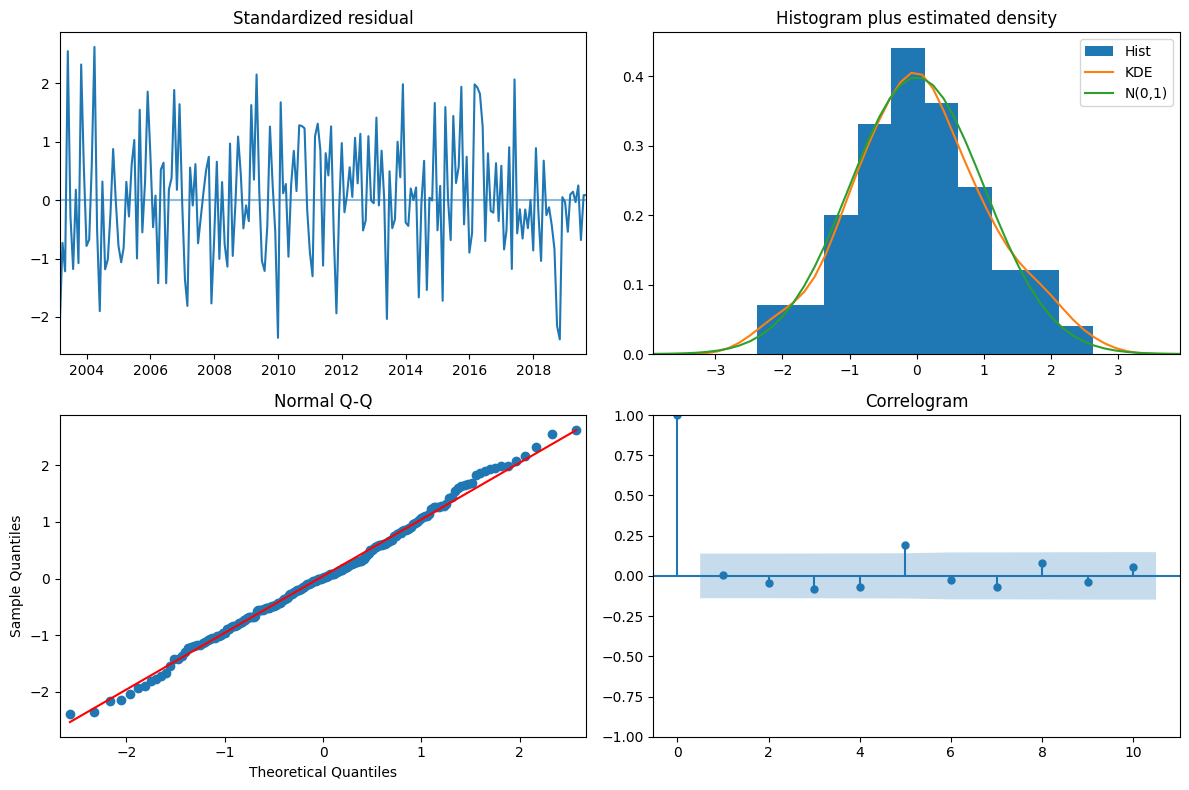

In [52]:
sarima.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

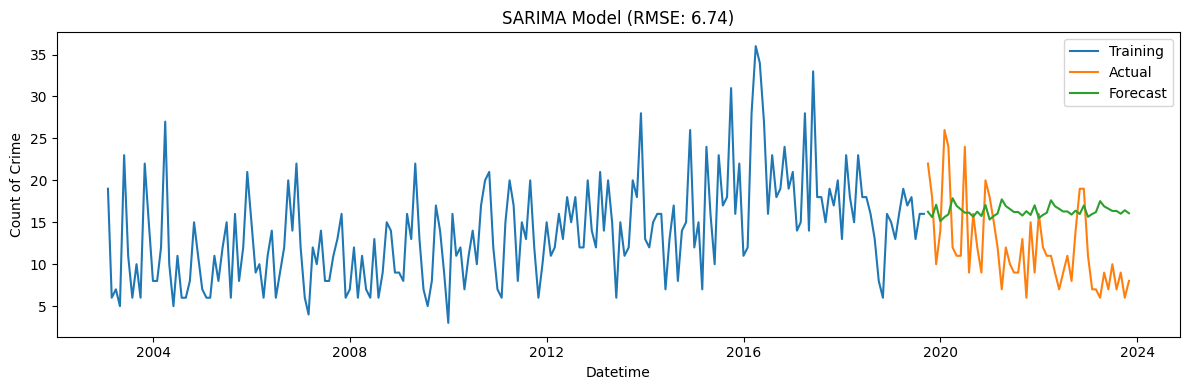

In [53]:
forecast = sarima.predict(len(valid))
forecast = inv_boxcox(pd.Series(forecast, index=valid.index), optimal_lambda)
sarima_rmse = mean_squared_error(valid, forecast, squared=False)

# Plotting the forecast
plot_forecast(forecast, 'SARIMA Model', sarima_rmse)

# Manual plotting

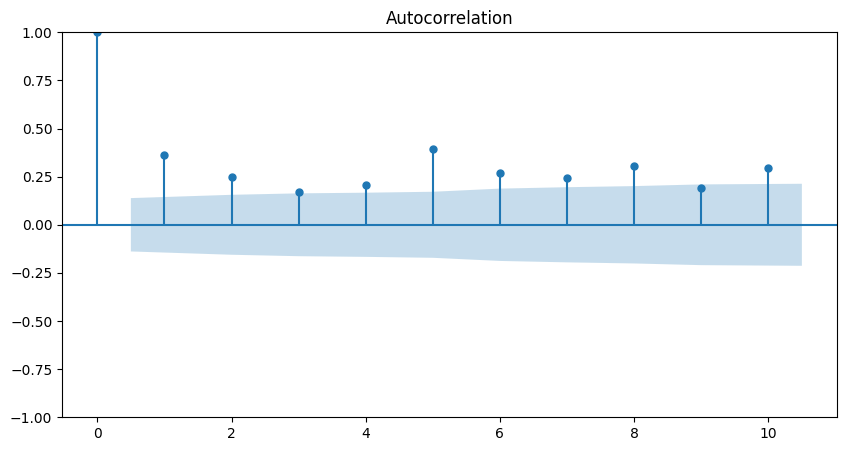

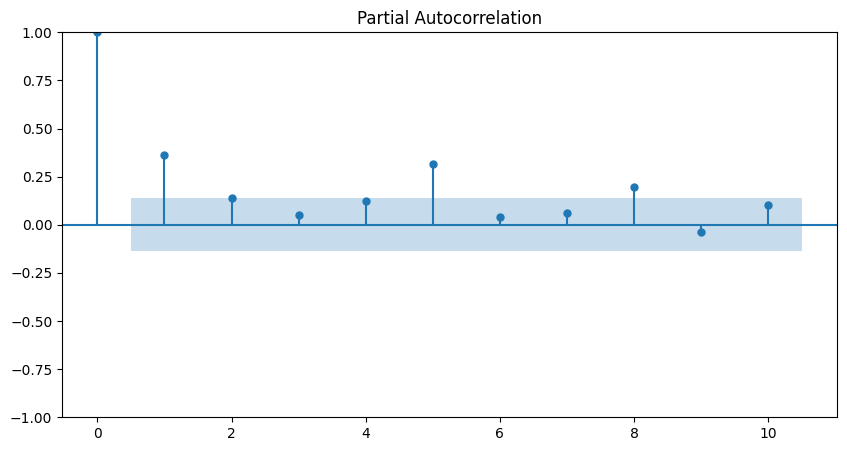

In [54]:
# Plot ACF:
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(train, ax=ax, lags=10)  # Adjust the number of lags as needed.
plt.show()

# Plot PACF:
fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(train, ax=ax, lags=10)  # Adjust the number of lags as needed.
plt.show()

# Facebook Prophet

In [55]:
train_df = train.copy()
valid_df = valid.copy()
for df in [train_df, valid_df]:
    df.reset_index(inplace=True)
    df.columns = ['ds', 'y']
    # Removing timezone information from datetime object
    df['ds'] = df['ds'].apply(lambda x: x.replace(tzinfo=None))

future = valid_df.drop(columns='y')
train_df.head()

,ds,y
0,2003-01-31,19
1,2003-02-28,6
2,2003-03-31,7
3,2003-04-30,5
4,2003-05-31,23


DEBUG:cmdstanpy:input tempfile: /tmp/tmp30tom1ok/u686ejli.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp30tom1ok/h6ee4l7d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88921', 'data', 'file=/tmp/tmp30tom1ok/u686ejli.json', 'init=/tmp/tmp30tom1ok/h6ee4l7d.json', 'output', 'file=/tmp/tmp30tom1ok/prophet_model1fuzgxgx/prophet_model-20231114075927.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:59:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:59:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


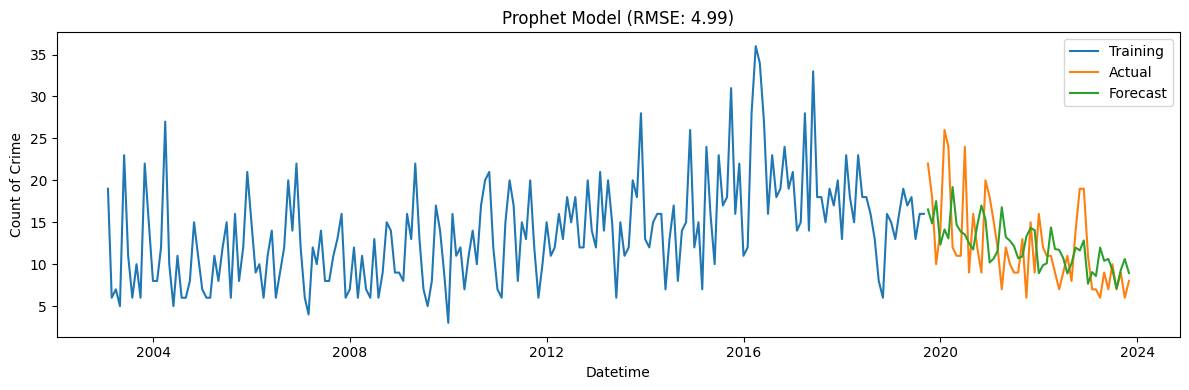

In [56]:
# Applying Prophet model
prophet = Prophet(weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=True, seasonality_mode='additive', changepoint_prior_scale=0.5)
prophet.fit(train_df)
predictions = prophet.predict(future)
forecast = predictions[['ds', 'yhat']]
forecast.set_index('ds', inplace = True)
prophet_rmse = mean_squared_error(valid, forecast, squared=False)

# Plotting the forecast
plot_forecast(forecast, 'Prophet Model', prophet_rmse)

By far Prophet model outperforms the rest. Hence, let's use the Prophet model to forecast for the whole dataset.

In [105]:
# Applying Prophet model
train_df = train.copy()
valid_df = valid.copy()

full_df = pd.concat([train_df, valid_df])
full_df.reset_index(inplace=True)
full_df.columns = ['ds', 'y']
full_df['ds'] = full_df['ds'].apply(lambda x: x.replace(tzinfo=None))

prophet = Prophet(weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=True, seasonality_mode='additive', changepoint_prior_scale=0.5)
prophet.fit(full_df)

future_combined = prophet.make_future_dataframe(periods=6, freq = 'm', include_history = False)

predictions = prophet.predict(future_combined)
forecast = predictions[['ds', 'yhat']]
forecast.set_index('ds', inplace = True)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp30tom1ok/sfu44i4l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp30tom1ok/7knw709q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26869', 'data', 'file=/tmp/tmp30tom1ok/sfu44i4l.json', 'init=/tmp/tmp30tom1ok/7knw709q.json', 'output', 'file=/tmp/tmp30tom1ok/prophet_model6ttg9vr0/prophet_model-20231114084118.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:41:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:41:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Then using the whole available dataset as training data, this is the forecast we get.

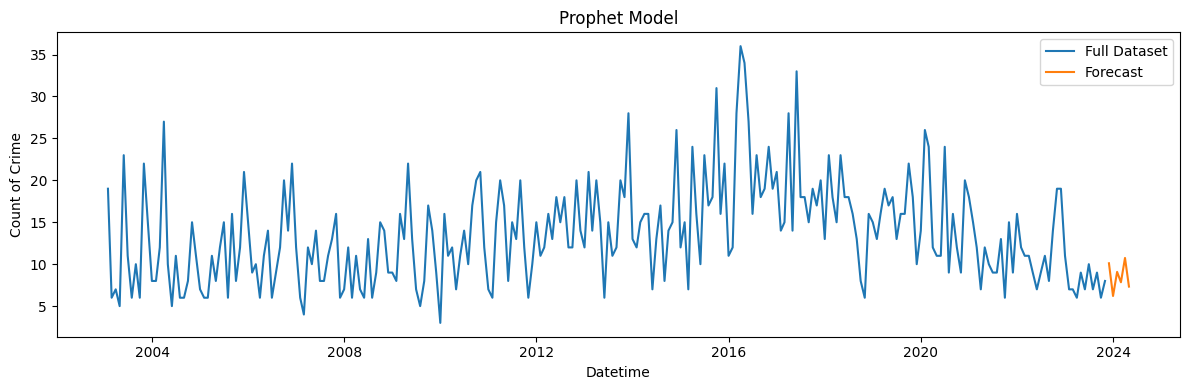

In [106]:
full_df = full_df.set_index('ds')
plt.figure(figsize=(12,4))
plt.plot(full_df, label='Full Dataset')
plt.plot(forecast, label='Forecast')
plt.xlabel('Datetime')
plt.ylabel('Count of Crime')
plt.title(f'Prophet Model')
plt.legend()
plt.tight_layout()
plt.show()